In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import Python Modules

In [2]:
# Main PODPAC library
import podpac

# Data source nodes
from podpac.datalib.smap_egi import SMAP
from podpac.datalib.drought_monitor import DroughtMonitorCategory

# Algorithm nodes
from podpac.algorithm import YearSubstituteCoordinates, Arithmetic

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


# Retrieve Data 
## Computed Drought Categories
* We computed these categories from historical SMAP data and staged the results on AWS S3. 
* To access these datasets, our specific AWS credentials are required.

In [3]:
# AWS bucket where data lives
bucket = "podpac-internal-test"
# Name of the file, in 'zarr' format
store = "drought_parameters.zarr"
# Path used by PODPAC to retrieve the data
source = 's3://%s/%s' % (bucket, store)


# Create the node that points to the .zarr file on S3
d0_source = DroughtMonitorCategory(datakey='d0', source=source)

# All of our data uses the year '2018', but really describe a climatology. 
# Hence, any incoming requests should have the year replaced by '2018'
year = '2018'

# This algorithm node take the incoming request, replaces the year by 2018, evaluates the d0_source node, then substitutes the original date in the result
d0 = YearSubstituteCoordinates(year=year, source=d0_source, substitute_eval_coords=True)

# Repeat for the other categories
d1 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d1', source=source), year=year, substitute_eval_coords=True)
d2 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d2', source=source), year=year, substitute_eval_coords=True)
d3 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d3', source=source), year=year, substitute_eval_coords=True)
d4 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d4', source=source), year=year, substitute_eval_coords=True)

## Raw SMAP Soil Moisture Data
* We retrieve this data from NSIDC through the EGI (Earthdata Gateway Interface). 
* We retrieve level 3 data that have AM and PM returns, and we composite them together.

In [4]:
# Get combined smap data
smap_e_am = SMAP(product='SPL3SMP_E_AM', page_size=40)
smap_e_pm = SMAP(product='SPL3SMP_E_PM', page_size=40)
smap = podpac.compositor.OrderedCompositor(sources=[smap_e_am,
                                                    smap_e_pm,
                                                   ], source='SMAP L3 AM/PM Combined')

# Create algorithm to convert raw SMAP data to drought categories
* We use an Arithmetic node computes pixel-wise results using an arbitrary equation
* The inputs come from the previously-created nodes, with an A, B, C,... naming convention

In [5]:
# Create the drought Categorization algorithm
alg = Arithmetic(A=d0, B=d1, C=d2, D=d3, E=d4, F=smap, params={'dn': 0.5, 'd5': 0},
                eqn=('(F > {d5}) * (F < E) * ((F - {d5}) / (E - {d5}) + 0) + '
                     '(F > E) * (F < D) * ((F - E) / (D - E) + 1) + '
                     '(F > D) * (F < C) * ((F - D) / (C - D) + 2) + '
                     '(F > C) * (F < B) * ((F - C) / (B - C) + 3) + '
                     '(F > B) * (F < A) * ((F - B) / (A - B) + 4) + '
                     '(F > A) * (F < {dn}) * ((F - A) / ({dn} - A) + 5) + '
                     '(F > {dn}) * 5.5'
                    )
                )

# Test the PODPAC Algorithm Locally
## Create Coordinates
* The nodes will be evaluated at these coordinates. 
* **Note**: the time series of the categories and the SMAP data do not line up, but PODPAC deals with the automatically using nearest-neighbor interpolation (by default). 

In [6]:
coords = podpac.Coordinates([43, -72, podpac.crange('2019-04-12', '2019-07-10', '3,D')], ['lat', 'lon', 'time'])

## Evaluate the Node Locally

In [7]:
# Most of the execution time comes from retrieving SMAP data via EGI
# The results of this request is cached, so subsequent eval's are fast
o = alg.eval(coords)  

## Examine the results

C:\Anaconda3\envs\podpac\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


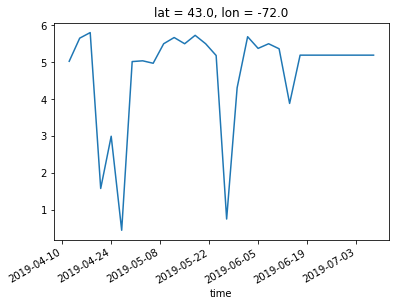

In [8]:
o.plot()

## Evaluate the Node on the Cloud

In [9]:
aws_node = podpac.core.managers.aws_lambda.Lambda(source=alg)

In [ ]:
# This may time out before a result is available, but the cell can be re-evaluated and previously computed results will be available on S3. 
o2 = aws_node.eval(coords)

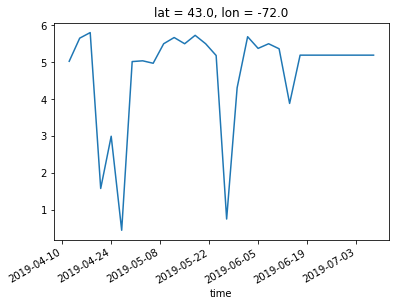

In [14]:
o2.plot()

# Export PODPAC Pipelines for development of website
* **Note**, PODPAC kept track of all the nodes used to create the analysis, and recorded this in a light-weight JSON format

In [15]:
def save_json(node, filename):
    with open(filename, 'w') as fid:
        fid.write(node.json_pretty)
        
save_json(d0, 'd0_pipeline.json')
save_json(d1, 'd1_pipeline.json')
save_json(d2, 'd2_pipeline.json')
save_json(d3, 'd3_pipeline.json')
save_json(d4, 'd4_pipeline.json')
save_json(alg, 'category_pipeline.json')
save_json(smap, 'smap_pipeline.json')

print (alg.json_pretty)

{
    "nodes": {
        "DroughtMonitorCategory": {
            "node": "datalib.drought_monitor.DroughtMonitorCategory",
            "attrs": {
                "altkey": "alt",
                "crs": null,
                "datakey": "d0",
                "latkey": "lat",
                "lonkey": "lon",
                "timekey": "time"
            },
            "source": "s3://podpac-internal-test/drought_parameters.zarr",
            "interpolation": "nearest"
        },
        "YearSubstituteCoordinates": {
            "node": "core.algorithm.coord_select.YearSubstituteCoordinates",
            "attrs": {
                "substitute_eval_coords": true,
                "year": "2018"
            },
            "inputs": {
                "source": "DroughtMonitorCategory"
            }
        },
        "DroughtMonitorCategory_1": {
            "node": "datalib.drought_monitor.DroughtMonitorCategory",
            "attrs": {
                "altkey": "alt",
                "crs":